# Diffusion for Audio

In this notebook, we're going to take a brief look at generating audio with diffusion models.

## What you will learn:
- How audio is represented in a computer
- Methods to convert between raw audio data and spectrograms
- How to prepare a dataloader with a custom collate function to convert audio slices into spectrograms
- Fine-tuning an existing audio diffusion model on a specific genre of music
- Uploading your custom pipeline to the Hugging Face hub

Caveat: This is mostly for educational purposes - no guarantees our model will sound good 😉.

Let's get started!

## Setup and Imports

In [1]:
#%pip install -q datasets diffusers torchaudio accelerate

In [2]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline
from torchaudio import transforms as AT
from torchvision import transforms as IT

## Sampling from a Pre-Trained Audio Pipeline

Let's begin by following the [Audio Diffusion docs](https://huggingface.co/docs/diffusers/api/pipelines/audio_diffusion) to load a pre-existing audio diffusion model pipeline:

In [3]:
# Load a pre-trained audio diffusion pipeline
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)

model_index.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

mel_config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--teticio--audio-diffusion-instrumental-hiphop-256/snapshots/a63b0c7e794925f74f021d356c13bce47cb69264/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--teticio--audio-diffusion-instrumental-hiphop-256/snapshots/a63b0c7e794925f74f021d356c13bce47cb69264/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'diffusers.models.unets.unet_2d.UNet2DModel'>.


As with the pipelines we've used in previous units, we can create samples by calling the pipeline like so:

  0%|          | 0/1000 [00:00<?, ?it/s]

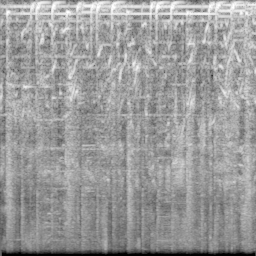

In [4]:
# Sample from the pipeline and display the outputs
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

Here, the `rate` argument specifies the _sampling rate_ for the audio; we'll take a deeper look at this later. You'll also notice there are multiple things returned by the pipeline. What's going on here? Let's take a closer look at both outputs.

The first is an array of data, representing the generated audio:

In [5]:
# The audio array
output.audios[0].shape

(1, 130560)

The second looks like a greyscale image:

In [6]:
# The output image (spectrogram)
output.images[0].size

(256, 256)

This gives us a hint at how this pipeline works. The audio is not directly generated with diffusion - instead, the pipeline has the same kind of 2D UNet as the unconditional image generation pipelines we saw in [Unit 1](https://github.com/huggingface/diffusion-models-class/tree/main/unit1) that is used to generate the spectrogram, which is then post-processed into the final audio.

The pipe has an extra component that handles these conversions, which we can access via `pipe.mel`:

In [7]:
pipe.mel

Mel {
  "_class_name": "Mel",
  "_diffusers_version": "0.35.2",
  "hop_length": 512,
  "n_fft": 2048,
  "n_iter": 32,
  "sample_rate": 22050,
  "top_db": 80,
  "x_res": 256,
  "y_res": 256
}

## From Audio to Image and Back Again



An audio 'waveform' encodes the raw audio samples over time - this could be the electrical signal received from a microphone, for example. Working with this 'Time Domain' representation can be tricky, so it is a common practice to convert it into some other form, commonly something called a spectrogram. A spectrogram shows the intensity of different frequencies (y axis) vs time (x axis):

tensor(1.3878e-15) tensor(2.8806)


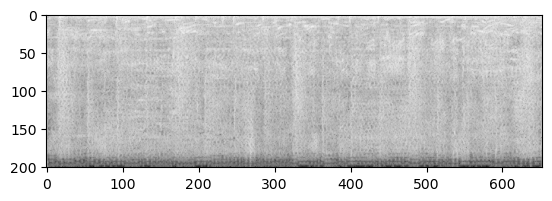

In [8]:
# Calculate and show a spectrogram for our generated audio sample using torchaudio
spec_transform = AT.Spectrogram(power=2)
spectrogram = spec_transform(torch.tensor(output.audios[0]))
print(spectrogram.min(), spectrogram.max())
log_spectrogram = spectrogram.log()
plt.imshow(log_spectrogram[0], cmap='gray');

The spectrogram we just made has values between 0.0000000000001 and 1, with most being close to the low end of that range. This is not ideal for visualization or modelling - in fact we had to take the log of these values to get a greyscale plot that showed any detail. For this reason, we typically use a special kind of spectrogram called a Mel spectrogram, which is designed to capture the kinds of information which are important for human hearing by applying some transforms to the different frequency components of the signal. 

![torchaudio docs diagram](https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png)
_Some audio transforms from the [torchaudio docs](https://pytorch.org/audio/stable/transforms.html)_

Luckily for us, we don't even need to worry too much about these transforms - the pipeline's `mel` functionality handles these details for us. Using this, we can convert a spectrogram image to audio like so:

In [9]:
a = pipe.mel.image_to_audio(output.images[0])
a.shape

(130560,)

And we can convert an array of audio data into a spectrogram images by first loading the raw audio data and then calling the `audio_slice_to_image()` function. Longer clips are automatically sliced into chunks of the correct length to produce a 256x256 spectrogram image:

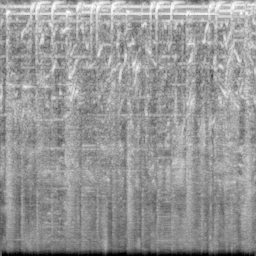

In [10]:
pipe.mel.load_audio(raw_audio=a)
im = pipe.mel.audio_slice_to_image(0)
im

The audio is represented as a long array of numbers. To play this out loud we need one more key piece of information: the sample rate. How many samples (individual values) do we use to represent a single second of audio? 

We can see the sample rate used during training of this pipeline with:

In [11]:
sample_rate_pipeline = pipe.mel.get_sample_rate()
sample_rate_pipeline

22050

If we specify the sample rate incorrectly, we get audio that is sped up or slowed down:

In [12]:
display(Audio(output.audios[0], rate=44100)) # 2x speed

## Fine-Tuning the pipeline

Now that we have a rough understanding of how the pipeline works, let's fine-tune it on some new audio data!

The dataset is a collection of audio clips in different genres, which we can load from the hub like so:

In [13]:
from datasets import load_dataset
dataset = load_dataset('lewtun/music_genres', split='train')
dataset

README.md:   0%|          | 0.00/545 [00:00<?, ?B/s]

data/train-00000-of-00016-6b5481c76a3d27(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00001-of-00016-438bb9cb7b0600(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00002-of-00016-c1a616564aeae4(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00003-of-00016-73a29e154975c4(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00004-of-00016-db37b9fc5526f4(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00005-of-00016-93716f27870408(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00006-of-00016-5d90eeed316ceb(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00007-of-00016-92ae3797361c8d(…):   0%|          | 0.00/492M [00:00<?, ?B/s]

data/train-00008-of-00016-26222f00247344(…):   0%|          | 0.00/484M [00:00<?, ?B/s]

data/train-00009-of-00016-54aecc0dd7ee20(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00010-of-00016-3828cc45b664a4(…):   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00011-of-00016-6e3dc52ec46ea7(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00012-of-00016-610de7a10e23d5(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00013-of-00016-b0af0a9e4b167b(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00014-of-00016-f224b1ff8d7d44(…):   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00015-of-00016-f1c3cbe5e2cccd(…):   0%|          | 0.00/488M [00:00<?, ?B/s]

data/test-00000-of-00004-2e0b9f634f1aec7(…):   0%|          | 0.00/495M [00:00<?, ?B/s]

data/test-00001-of-00004-f199d70ca2b5330(…):   0%|          | 0.00/497M [00:00<?, ?B/s]

data/test-00002-of-00004-f34d5fd400a9f24(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

data/test-00003-of-00004-00213d3ef9894ab(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19909 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5076 [00:00<?, ? examples/s]

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

You can use the code below to see the different genres in the dataset and how many samples are contained in each:

In [14]:
for g in list(set(dataset['genre'])):
  print(g, sum(x==g for x in dataset['genre']))

Ambient Electronic 796
Folk 1214
Punk 2582
Pop 945
Old-Time / Historic 408
Experimental 1800
Hip-Hop 1757
Classical 495
Rock 3095
Country 142
Chiptune / Glitch 1181
Jazz 306
International 814
Electronic 3071
Soul-RnB 94
Easy Listening 13
Blues 58
Spoken 94
Instrumental 1044


The dataset has the audio as arrays:

In [15]:
audio_array = dataset[0]['audio']['array']
sample_rate_dataset = dataset[0]['audio']['sampling_rate']
print('Audio array shape:', audio_array.shape)
print('Sample rate:', sample_rate_dataset)
display(Audio(audio_array, rate=sample_rate_dataset))

Audio array shape: (1323119,)
Sample rate: 44100


Note that the sample rate of this audio is higher - if we want to use the existing pipeline we'll need to 'resample' it to match. The clips are also longer than the ones the pipeline is set up for. Fortunately, when we load the audio using `pipe.mel` it automatically slices the clip into smaller sections:

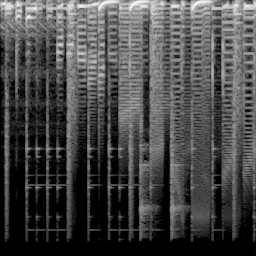

In [16]:
a = dataset[0]['audio']['array'] # Get the audio array
pipe.mel.load_audio(raw_audio=a) # Load it with pipe.mel
pipe.mel.audio_slice_to_image(0) # View the first 'slice' as a spectrogram

We need to remember to adjust the sampling rate, since the data from this dataset has twice as many samples per second:

In [17]:
sample_rate_dataset = dataset[0]['audio']['sampling_rate']
sample_rate_dataset

44100

Here we use torchaudio's transforms (imported as AT) to do the resampling, the pipe's `mel` to turn audio into an image and torchvision's transforms (imported as IT) to turn images into tensors. This gives us a function that turns an audio clip into a spectrogram tensor that we can use for training:

In [18]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline, dtype=torch.float32)
to_t = IT.ToTensor()

def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32)
  audio_tensor = resampler(audio_tensor)
  pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = pipe.mel.get_number_of_slices()
  slice_idx = random.randint(0, num_slices-1) # Pic a random slice each time (excluding the last short slice)
  im = pipe.mel.audio_slice_to_image(slice_idx) 
  return im

We'll use our `to_image()` function as part of a custom collate function to turn our dataset into a dataloader we can use for training. The collate function defines how to transform a batch of examples from the dataset into the final batch of data ready for training. In this case we turn each audio sample into a spectrogram image and stack the resulting tensors together:

In [19]:
def collate_fn(examples):
  # to image -> to tensor -> rescale to (-1, 1) -> stack into batch
  audio_ims = [to_t(to_image(x['audio']['array']))*2-1 for x in examples]
  return torch.stack(audio_ims)

# Create a dataset with only the 'Chiptune / Glitch' genre of songs
batch_size = 4 # 4 on colab, 12 on A100
chosen_genre = 'Electronic' # <<< Try training on different genres <<<
indexes = [i for i, g in enumerate(dataset['genre']) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
dl = torch.utils.data.DataLoader(filtered_dataset.shuffle(), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
batch = next(iter(dl))
print(batch.shape)

torch.Size([4, 1, 256, 256])


**NB: You will need to use a lower batch size (e.g., 4) unless you have plenty of GPU vRAM available.**

## Training Loop

Here is a simple training loop that runs through the dataloader for a few epochs to fine-tune the pipeline's UNet. You can also skip this cell and load the pipeline with the code in the following cell.

In [24]:
epochs = 3
lr = 1e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):
        
        # Prepare the input images
        clean_images = batch.to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, pipe.scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

  0%|          | 0/768 [00:00<?, ?it/s]

In [ ]:
pipe.save_pretrained("models/diffusion_for_audio")
#pipe = DiffusionPipeline.from_pretrained("models/diffusion_for_audio")

In [26]:
# OR: Load the version I trained earlier
#pipe = DiffusionPipeline.from_pretrained("johnowhitaker/Electronic_test").to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

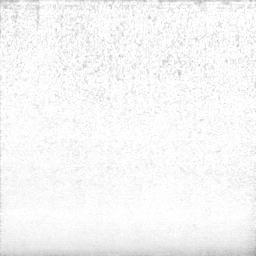

In [27]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

  0%|          | 0/1000 [00:00<?, ?it/s]

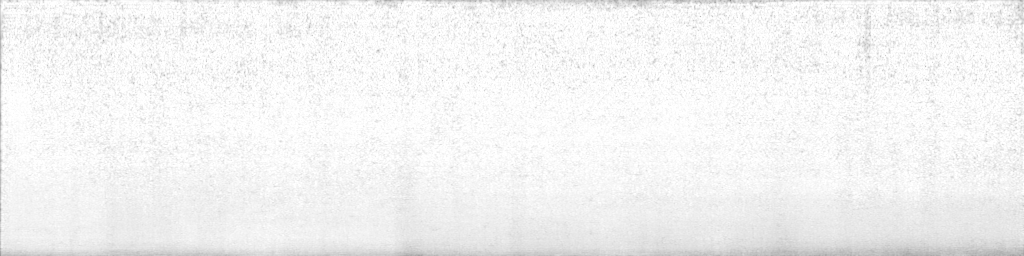

In [30]:
# Make a longer sample by passing in a starting noise tensor with a different shape
noise = torch.randn(1, 1, pipe.unet.sample_size, pipe.unet.sample_size*4).to(device)
output = pipe(noise=noise)
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

In [31]:
pipe.unet.sample_size

256

Not the most amazing-sounding outputs, but it's a start :) Explore tweaking the learning rate and number of epochs, and share your best results on Discord so we can improve together!

Some things to consider:
- We're working with 256px square spectrogram images which limits our batch size. Can you recover audio of sufficient quality from a 128x128 spectrogram?
- In place of random image augmentation we're picking different slices of the audio clip each time, but could this be improved with some different kinds of augmentation when training for many epochs?
- How else might we use this to generate longer clips? Perhaps you could generate a 5s starting clip and then use inpainting-inspired ideas to continue to generate additional segments of audio that follow on from the initial clip...
- What is the equivalent of image-to-image in this spectrogram diffusion context?

## Push to Hub

Once you're happy with your model, you can save it and push it to the hub for others to enjoy:

In [36]:
from huggingface_hub import get_full_repo_name, HfApi, create_repo, ModelCard, login

In [37]:
login()

In [38]:
# Pick a name for the model
model_name = "audio-diffusion-electronic"
hub_model_id = get_full_repo_name(model_name)

In [39]:
# Save the pipeline locally
pipe.save_pretrained(model_name)

In [40]:
# Inspect the folder contents
!ls {model_name}

mel  model_index.json  scheduler  unet


In [41]:
# Create a repository
create_repo(hub_model_id)

RepoUrl('https://huggingface.co/AlexChalk/audio-diffusion-electronic', endpoint='https://huggingface.co', repo_type='model', repo_id='AlexChalk/audio-diffusion-electronic')

In [42]:
# Upload the files
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="scheduler", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/mel", path_in_repo="mel", repo_id=hub_model_id
)
api.upload_folder(folder_path=f"{model_name}/unet", path_in_repo="unet", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/AlexChalk/audio-diffusion-electronic/commit/670cfe8d2568db7f68c17c823762b651386e0ab8', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='670cfe8d2568db7f68c17c823762b651386e0ab8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AlexChalk/audio-diffusion-electronic', endpoint='https://huggingface.co', repo_type='model', repo_id='AlexChalk/audio-diffusion-electronic'), pr_revision=None, pr_num=None)

In [43]:
# Push a model card
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-audio-generation
- diffusion-models-class
---

# Model Card for Unit 4 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional audio generation of music in the genre {chosen_genre}

## Usage

<pre>
from IPython.display import Audio
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("{hub_model_id}")
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))
</pre>
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/AlexChalk/audio-diffusion-electronic/commit/97a7c20d586dfe5d87d7d740230b65b019b83e98', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='97a7c20d586dfe5d87d7d740230b65b019b83e98', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AlexChalk/audio-diffusion-electronic', endpoint='https://huggingface.co', repo_type='model', repo_id='AlexChalk/audio-diffusion-electronic'), pr_revision=None, pr_num=None)

## Conclusion

This notebook has hopefully given you a small taste of the potential of audio generation. Check out some of the references linked from the introduction to this unit to see some fancier methods and the astounding samples they can create!